# Differences in Capitalization in Spam and Non-Spam Email

## Introduction

The `Spambase` dataset is a collection of assorted emails. Its variables include the frequencies of various words, lengths of capital letter sequences, and class: spam(1) or non-spam(0).

Spam email is unsolicited bulk email, often explicit or commercial, and has been an issue since the 1990s (Cranor et al., 1998, p.74). Spam is low-cost to send, but burdens service providers and recipients. While declining as of 2013, spam has become sophisticated, disguising itself from filters (Irani et al., 2013, p.2).

Due to spam's increasing complexity, additional work is needed to increase the efficacy of its detectors. To assist the construction of more practical spam filters, we will look for consistent content differences between spam and non-spam. We focus on the average length of sequences of capital letters, assuming that spam likely uses capitalization to create false urgency and garner attention.

The question we set out to answer is:

**"Is the mean average length of uninterrupted sequences of capital letters different for spam and non-spam email?"**

## Methods and Results

### Preliminary Results
We will first load the needed packages.

In [2]:
library(tidyverse)
library(repr)
library(cowplot)
library(infer)
library(broom)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp




We use `read.csv()` to read the dataset from the web. The data is already tidy, but we rename the columns with `col_names()` and convert 0 and 1 to 'non-spam' and 'spam' in the class variable.

In [3]:
spambase <- read.csv("https://raw.githubusercontent.com/rchanpra/stat-201-project/main/spambase/spambase.data")

In [4]:
colnames(spambase) <- c("word_freq_make","word_freq_address","word_freq_all","word_freq_3d","word_freq_our",
                        "word_freq_over","word_freq_remove","word_freq_internet","word_freq_order","word_freq_mail",
                        "word_freq_receive","word_freq_will","word_freq_people","word_freq_report","word_freq_addresses",
                        "word_freq_free","word_freq_business","word_freq_email","word_freq_you","word_freq_credit",
                        "word_freq_your","word_freq_font","word_freq_000","word_freq_money","word_freq_hp",
                        "word_freq_hpl","word_freq_george","word_freq_650","word_freq_lab","word_freq_labs",
                        "word_freq_telnet","word_freq_857","word_freq_data","word_freq_415","word_freq_85",
                        "word_freq_technology","word_freq_1999","word_freq_parts","word_freq_pm","word_freq_direct",
                        "word_freq_cs","word_freq_meeting","word_freq_original","word_freq_project", "word_freq_re",
                        "word_freq_edu","word_freq_table","word_freq_conference","char_freq_;","char_freq_(",
                        "char_freq_[","char_freq_!","char_freq_$","char_freq_#","capital_run_length_average",
                        "capital_run_length_longest","capital_run_length_total","class")

In [5]:
spambase <- spambase %>% 
    mutate(class = ifelse(class == 1, "spam", "non-spam"))

Here, we check the size of the dataset and take a peek at the first few rows.

In [6]:
print("Number of rows:")
nrow(spambase)

[1] "Number of rows:"


[1] 4600

In [7]:
print("Table 1: Original Spambase Dataframe")
head(spambase)

[1] "Table 1: Original Spambase Dataframe"


,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,⋯,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,class
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<chr>
1,0.21,0.28,0.50,0,0.14,0.28,0.21,0.07,0.00,0.94,⋯,0.00,0.132,0,0.372,0.180,0.048,5.114,101,1028,spam
2,0.06,0.00,0.71,0,1.23,0.19,0.19,0.12,0.64,0.25,⋯,0.01,0.143,0,0.276,0.184,0.010,9.821,485,2259,spam
3,0.00,0.00,0.00,0,0.63,0.00,0.31,0.63,0.31,0.63,⋯,0.00,0.137,0,0.137,0.000,0.000,3.537,40,191,spam
4,0.00,0.00,0.00,0,0.63,0.00,0.31,0.63,0.31,0.63,⋯,0.00,0.135,0,0.135,0.000,0.000,3.537,40,191,spam
5,0.00,0.00,0.00,0,1.85,0.00,0.00,1.85,0.00,0.00,⋯,0.00,0.223,0,0.000,0.000,0.000,3.000,15,54,spam
6,0.00,0.00,0.00,0,1.92,0.00,0.00,0.00,0.00,0.64,⋯,0.00,0.054,0,0.164,0.054,0.000,1.671,4,112,spam


Next, we select the needed columns, `capital_run_length_average` and `class`. Then, we compute the sample mean and standard deviation of the average run length of capital letters for each class, and the count of spam and non-spam.

In [8]:
# Considering that the dataset is a sample from the larger population of spam email,
# computing the mean and standard deviation of the word frequencies for each class produces our point estimates
# We select the columns we need (class and capital_run_length_average)

spambase_selected <- spambase %>% 
    select(capital_run_length_average,class)

spambase_stats <- spambase_selected %>% 
    group_by(class) %>% 
    summarize(mean_capital_run_length_average = mean(capital_run_length_average), 
              sd_capital_run_length_average = sd(capital_run_length_average), 
              n = n())

print("Table 2: Spambase Sample Statistics")
spambase_stats

[1] "Table 2: Spambase Sample Statistics"


class,mean_capital_run_length_average,sd_capital_run_length_average,n
<chr>,<dbl>,<dbl>,<int>
non-spam,2.377301,5.113685,2788
spam,9.522345,49.859762,1812


Now, we calculate the difference in means, spam minus non-spam.

In [9]:
diff_in_means <- spambase_stats$mean_capital_run_length_average[2] - spambase_stats$mean_capital_run_length_average[1]

print("Difference in means:")
diff_in_means

[1] "Difference in means:"


[1] 7.145045

Spam has a greater sample mean and standard deviation than non-spam email.

We visualize the sample distribution by using `geom_boxplot()` and `geom_histogram()` to plot a boxplot and histogram.

Warning message:
“Removed 189 rows containing non-finite values (`stat_boxplot()`).”


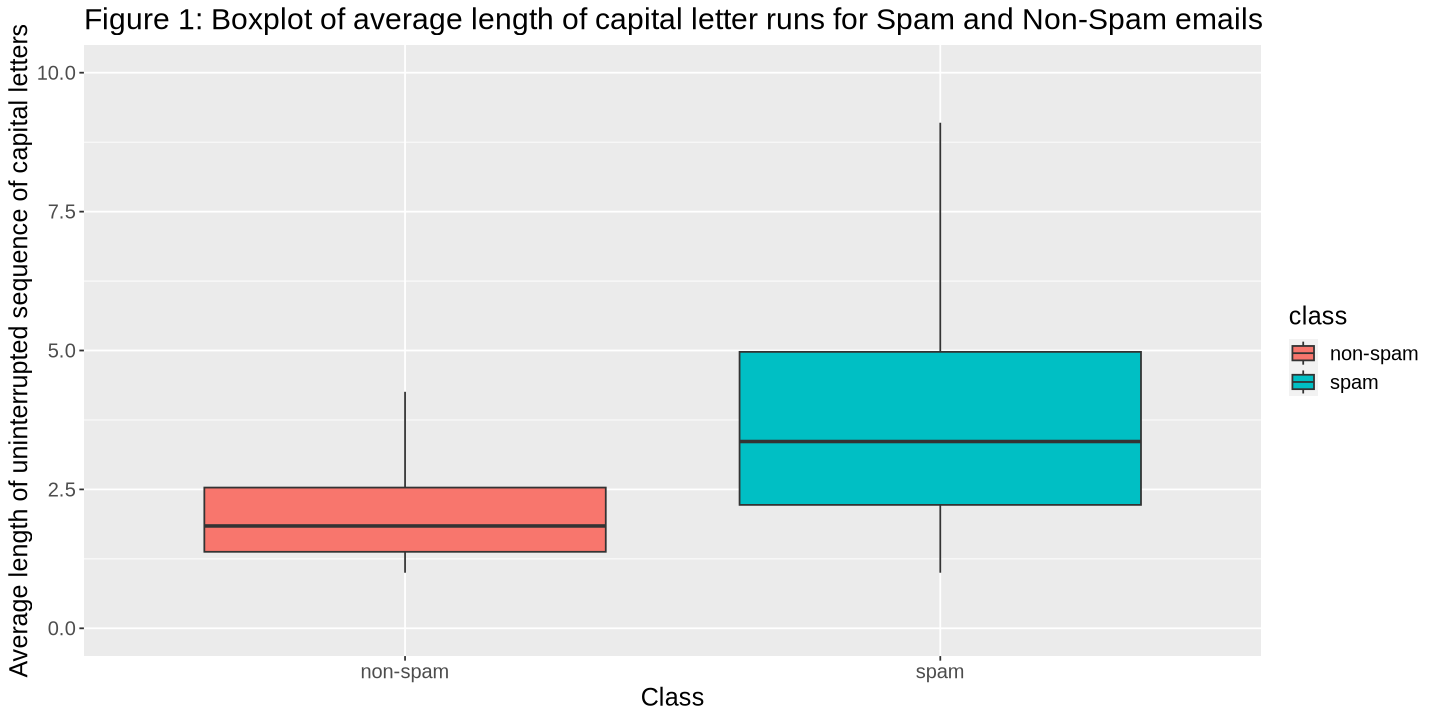

In [10]:
# Graph the distribution of variable of interest for each class, with vertical lines indicating the means of each class
spam_boxplot <- spambase_selected %>% 
    ggplot() + 
    geom_boxplot(aes(class, capital_run_length_average, fill = class), outlier.shape = NA) + 
    # we do not display some extreme values, which are impractical to plot
    scale_y_continuous(limits = c(0, 10)) + 
    theme(text = element_text(size = 15)) + 
    ggtitle("Figure 1: Boxplot of average length of capital letter runs for Spam and Non-Spam emails") + 
    xlab("Class") + 
    ylab("Average length of uninterrupted sequence of capital letters")

options(repr.plot.width = 12, repr.plot.height = 6)
spam_boxplot

Warning message:
“Removed 42 rows containing non-finite values (`stat_bin()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”
Warning message:
“Removed 1 rows containing non-finite values (`stat_bin()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”


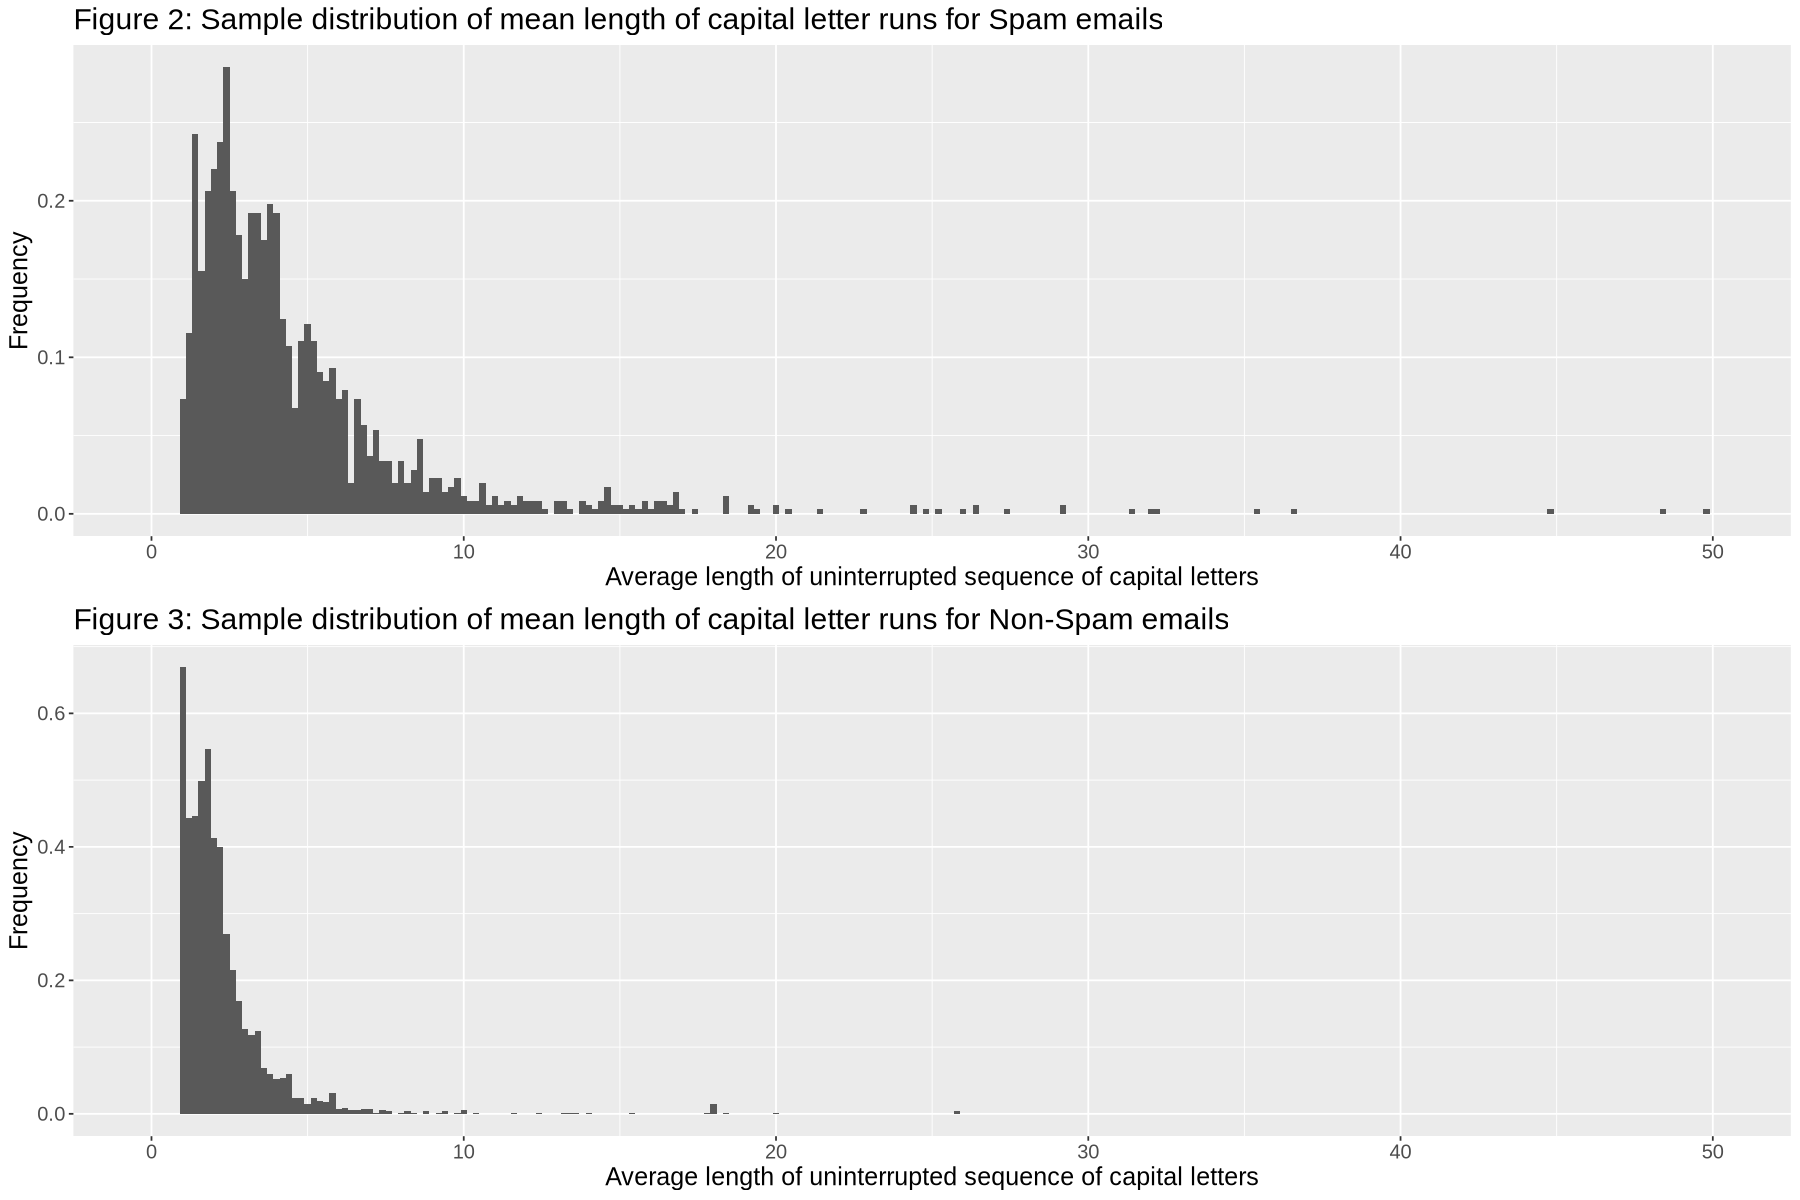

In [11]:
spam_histogram <- spambase_selected %>% 
    filter(class == "spam") %>% 
    ggplot() + 
    geom_histogram(aes(x = capital_run_length_average, y = after_stat(density)), binwidth = 0.2) + 
    # we do not display some extreme values, which are impractical to plot
    scale_x_continuous(limits = c(0, 50)) + 
    theme(text = element_text(size = 15)) + 
    ggtitle("Figure 2: Sample distribution of mean length of capital letter runs for Spam emails") + 
    ylab("Frequency") + 
    xlab("Average length of uninterrupted sequence of capital letters")

non_spam_histogram <- spambase_selected %>% 
    filter(class == "non-spam") %>% 
    ggplot() + 
    geom_histogram(aes(x = capital_run_length_average, y = after_stat(density)), binwidth = 0.2) + 
    # we do not display some extreme values, which are impractical to plot
    scale_x_continuous(limits = c(0, 50)) + 
    theme(text = element_text(size = 15)) + 
    ggtitle("Figure 3: Sample distribution of mean length of capital letter runs for Non-Spam emails") + 
    ylab("Frequency") + 
    xlab("Average length of uninterrupted sequence of capital letters")

options(repr.plot.width = 15, repr.plot.height = 10)
plot_grid(spam_histogram, non_spam_histogram, ncol = 1)

*Note: some larger values/outliers are not pictured in order to fit the majority of values.

Spam emails seem to typically have a greater average length and a wider spread. In the histogram, we can see that there are more spam emails with uninterrupted capital letter sequences longer than $10$, compared to spam emails.
The distributions for both spam and non-spam are unimodal and strongly right-skewed.

Based on these results, we might believe spam has longer capital letter sequences. For instance, an email with unusually long sequences of capitals would be suspect.

### Further Analysis

Assuming `Spambase` is a representative sample, our estimates of the mean values for capital letter sequences of spam and non-spam emails are likely good approximations of the true values, especially given the samples' large size. However, our point estimates do not provide any measure of how close they are likely to be to the true values: we do not know their uncertainty. We cannot present these results alone, further work is required.

Since the sample size is large for both groups ($1812$ spam, $2788$ non-spam), we can use the theory-based approach for further analysis, assuming the sampling distribution is approximately normal by the Central Limit Theorem. We are also able to use bootstrapping, which makes no such assumptions about how the sample statistic is distributed because bootstrapping simulates taking many samples to estimate the sampling distribution. We will use both theory-based and bootstrapping-based approaches.
We will use a significance level of $\alpha = 0.05$, a commonly used value. 

For our analysis, we will build two confidence intervals, one using bootstrapping, the other using asymptotics, of the difference in means to obtain a range of values that we are confident contains the true difference. We are $95\%$ confident, meaning that we would expect $95\%$ of total such confidence intervals to capture the true difference in means. For instance, if we constructed $100$ such intervals using different samples, we would expect $95$ of them to contain the true difference in means.

We will two hypothesis tests for the difference in means, one using bootstrapping, the other theory-based, with $H_0: \mu_1 = \mu_0$ vs $H_1: \mu_1\gt \mu_0$, where $1$ and $0$ represent spam and non-spam. If spam email has a larger mean average than non-spam, we would expect to gain evidence of it from these inferences. If our results are significant, we will be able to safely reject the null hypothesis, and conclude that the mean capital letter sequence length of spam is greater than that of non-spam. Our probability of incorrectly rejecting the null hypothesis (Type I Error) is $0.05$.


#### Bootstrap Confidence Interval
We start by constructing a $95\%$ confidence interval for the difference in the mean capital letter usage between spam and non-spam emails using bootstrapping, which gives us a better idea about the difference in means of the two groups, spam and non-spam. 

We are using the `infer` package workflow to estimate the distribution of the difference in means, specifying the formula in `specify()`, generating $1000$ bootstrap samples with `generate()`, and using `calculate()` to find the difference in means for each sample. Passing the distribution to `get_confidence_interval` then returns a tibble with a lower and upper bound for the difference.

In [12]:
set.seed(1048596)

spam_bootstrap_dist <- spambase_selected %>% 
    specify(formula = capital_run_length_average ~ class) %>% 
    generate(reps = 1000, type = "bootstrap") %>% 
    calculate(stat = "diff in means", order = c("spam", "non-spam"))
    
spam_ci <- spam_bootstrap_dist %>% 
    get_confidence_interval(level = 0.95, type = "percentile")

print("Table 3: Confidence Interval (Bootstrapping) For Spambase")
spam_ci # here's a 95% confidence interval for the difference in mean capital letter sequence lengths, in spam email

[1] "Table 3: Confidence Interval (Bootstrapping) For Spambase"


lower_ci,upper_ci
<dbl>,<dbl>
5.059496,9.755062


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


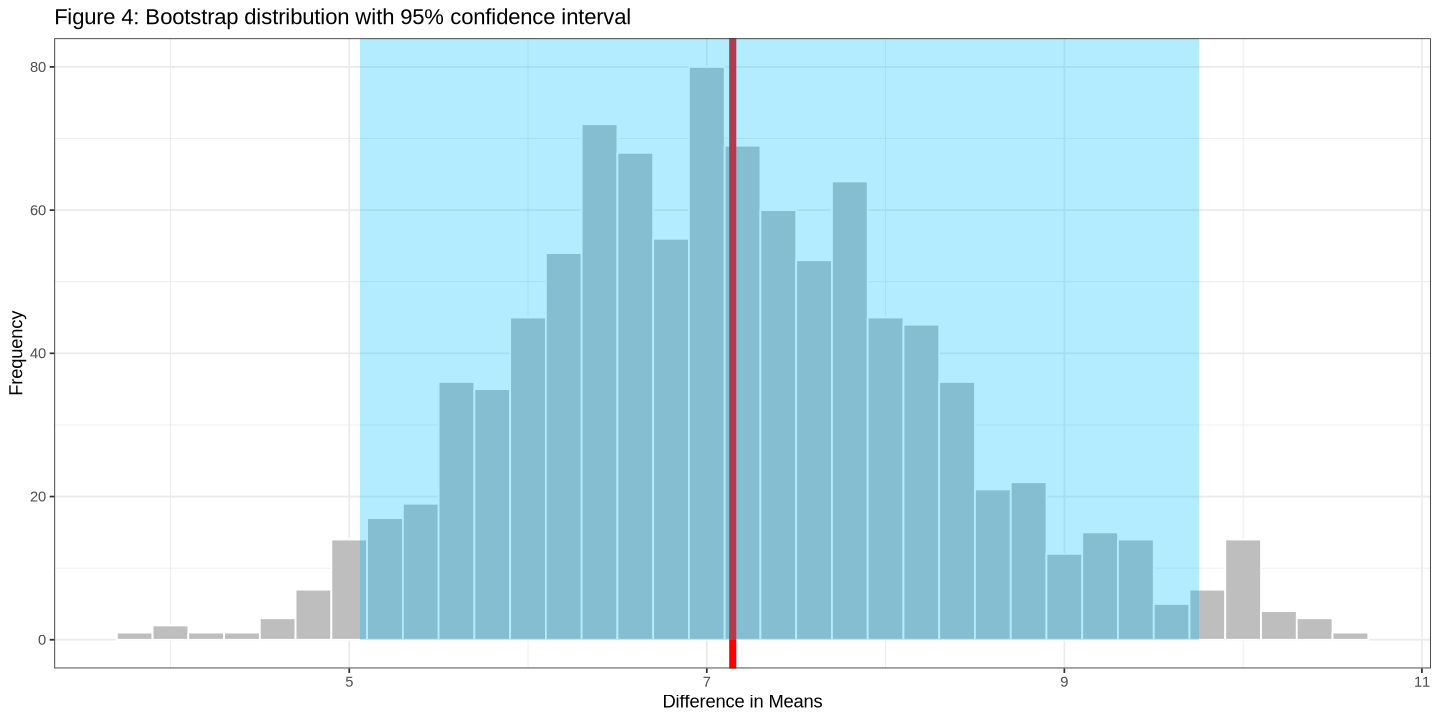

In [13]:
spam_ci_plot <- spam_bootstrap_dist %>% 
    ggplot(aes(x = stat)) + 
    geom_histogram(binwidth = 0.2, colour = "white", fill = "grey") + 
    geom_vline(xintercept = diff_in_means, size = 2, colour = "red") + 
    annotate("rect", xmin = spam_ci$lower_ci, xmax = spam_ci$upper_ci, ymin = 0, ymax = Inf, fill = "deepskyblue", alpha = 0.3) + 
    labs(title = "Figure 4: Bootstrap distribution with 95% confidence interval", x = "Difference in Means", y = "Frequency") + 
    theme(text = element_text(size = 20)) + 
    theme_bw()

options(repr.plot.width = 12, repr.plot.height = 6)
spam_ci_plot

Once plotted with `ggplot()` and `geom_histogram`, we can see that bootstrap distribution appears to be approximately normal.

We find that the lower bound for the difference in the mean average capital letter sequence length is $5.06$ and the upper bound is $9.76$. The confidence interval does not contain $0$ and both bounds are positive, which suggests that the true mean value of spam is greater than the mean of non-spam.

#### Theory-Based Confidence Interval
We double-check our bootstrapped confidence interval by calculating a confidence interval using a theory-based approach.  The emails are independent observations, the difference in means is an estimator that is a linear combination of random variables, and our samples are sufficiently large, with $1812$ spam and $2788$ non-spam observations. Samples are generally considered large enough when they have more than 20 or 30 observations. Regardless of which rule-of-thumb is used, our samples are large enough. By the Central Limit Theorem, we can assume the sampling distribution is approximately normal.

We use the `sd()`, `mean()`, and `qt()` functions to calculate the lower and upper bounds of the confidence interval. `sd()` calculates the sample standard deviation, `mean()` calculates the sample means, and `qt()` provides the corresponding t-score. We use the t-distribution instead of the normal distribution because we do not know the true population standard deviations, and approximate them with the sample standard deviations. This introduces additional variation that is accounted for by the t-distribution's longer, heavier tails.

In [14]:
set.seed(1337)

# Calculate important variables
spam_diff <- spambase_selected %>% 
    group_by(class) %>% 
    summarize(cap_length = mean(capital_run_length_average), 
              errs = sd(capital_run_length_average), 
              sqr_err = errs^2/n())
    
print("Table 4: Important Statistics Across Spam and Non-Spam Categories")
spam_diff

[1] "Table 4: Important Statistics Across Spam and Non-Spam Categories"


class,cap_length,errs,sqr_err
<chr>,<dbl>,<dbl>,<dbl>
non-spam,2.377301,5.113685,0.009379401
spam,9.522345,49.859762,1.371962395


In [20]:
spam_s <- sqrt(spam_diff$sqr_err[1] + spam_diff$sqr_err[2])
spam_x_bar <- spam_diff$cap_length[2] - spam_diff$cap_length[1] # spam - non-spam

df <- nrow(spambase_selected) - 2 # approximate the degrees of freedom, n1 + n0 - 2

# Create the confidence interval
theory_based_ci <- tibble(lower_ci = qt(0.025, df, spam_x_bar, spam_s), 
                          upper_ci = qt(0.975, df, spam_x_bar, spam_s))

print("Table 5: Theory-based confidence interval")
theory_based_ci

Warning message in qt(0.975, df, spam_x_bar, spam_s):
“full precision may not have been achieved in 'pnt{final}'”


[1] "Table 5: Theory-based confidence interval"


lower_ci,upper_ci
<dbl>,<dbl>
5.182502,9.114332


This confidence interval, (5.18, 9.11) closely resembles the one we determined using bootstrap samples, so we are more assured of our estimate of the range within which the difference in means can plausibly fall. This interval is narrower than the one derived from bootstrapping, possibly because we only generated 1000 bootstrap samples.

### Bootstrap Hypothesis Test

Our null hypothesis is that the mean average capital letter frequency is the same for spam versus non-spam email. The alternate hypothesis is that the mean average capital letter frequency is greater for spam versus non-spam email. 

$H_0: \mu_1 = \mu_0$ vs $H_1: \mu_1\gt \mu_0$

($1$ and $0$ represent spam and non-spam respectively)

We do a one-sided hypothesis test, because we believe that spam email will contain more capital letters on average than non-spam. We chose a significance level of $\alpha = 0.05$.

The null distribution is what our sampling distribution would look like if there was no difference between the means of average capital letter usage between the populations of spam and non-spam emails. By comparing our sample value to this model, we can determine how unusual our sample would be if the null hypothesis were true.

Here, we create the null model for this null hypothesis, again using the `infer` package workflow.

In [16]:
set.seed(1337) # set the seed

obs_diff_in_means <- spambase_selected %>% 
    specify(formula = capital_run_length_average ~ class) %>% 
    calculate(stat = "diff in means", order = c("spam", "non-spam"))

null_diff_in_means <- spambase_selected %>% 
    specify(formula = capital_run_length_average ~ class) %>% 
    hypothesize(null = "independence") %>% 
    generate(reps = 1000, type ="permute") %>% 
    calculate(stat = "diff in means", order = c("spam", "non-spam"))

print("Observed difference in means:")
as.numeric(obs_diff_in_means)
print("Table 6: Null difference in means")
head(null_diff_in_means)

[1] "Observed difference in means:"


[1] 7.145045

[1] "Table 6: Null difference in means"


replicate,stat
<int>,<dbl>
1,0.1945879
2,0.4259894
3,-0.5954865
4,0.2208838
5,-0.2896688
6,-1.0924126


Now, we use the function `get_p_value()` to calculate the $p$-value, which is the probability of observing a value as or more extreme as the sample's value, if the null hypothesis were true.

In [17]:
p_value <- null_diff_in_means %>% 
    get_p_value(obs_stat = obs_diff_in_means,direction = "right")

print("Table 7: P Value (Bootstrap Hypothesis Test)")
p_value

Warning message:
“Please be cautious in reporting a p-value of 0. This result is an approximation based on the number of `reps` chosen in the `generate()` step. See `?get_p_value()` for more information.”


[1] "Table 7: P Value (Bootstrap Hypothesis Test)"


p_value
<dbl>
0


We obtain the dubious $p$-value of $0$. The function `get_p_value()` may return $0$ when the observed statistic is extremely unlikely given the null hypothesis, but a small number of repetitions have been generated for the null distribution. Our observed statistic is more extreme than every test statistic generated to form the null distribution, resulting in an approximate $p$-value of $0$ (RDocumentation). The interpretation of a $p$-value of $0$ is that there is a $0\%$ probability of the obtaining such a result, which seems absurd. Although we could consider this sufficient evidence to reject the null hypothesis at the $0.05$ significance level, we will later utilize the theory-based method of conducting a hypothesis test to obtain a more conclusive result.

We can visualize the observed statistic on the null distribution to see why our work produced a $p$-value of $0$. The red bar in the plot is the observed difference in means.

Warning message in min(diff(unique_loc)):
“no non-missing arguments to min; returning Inf”


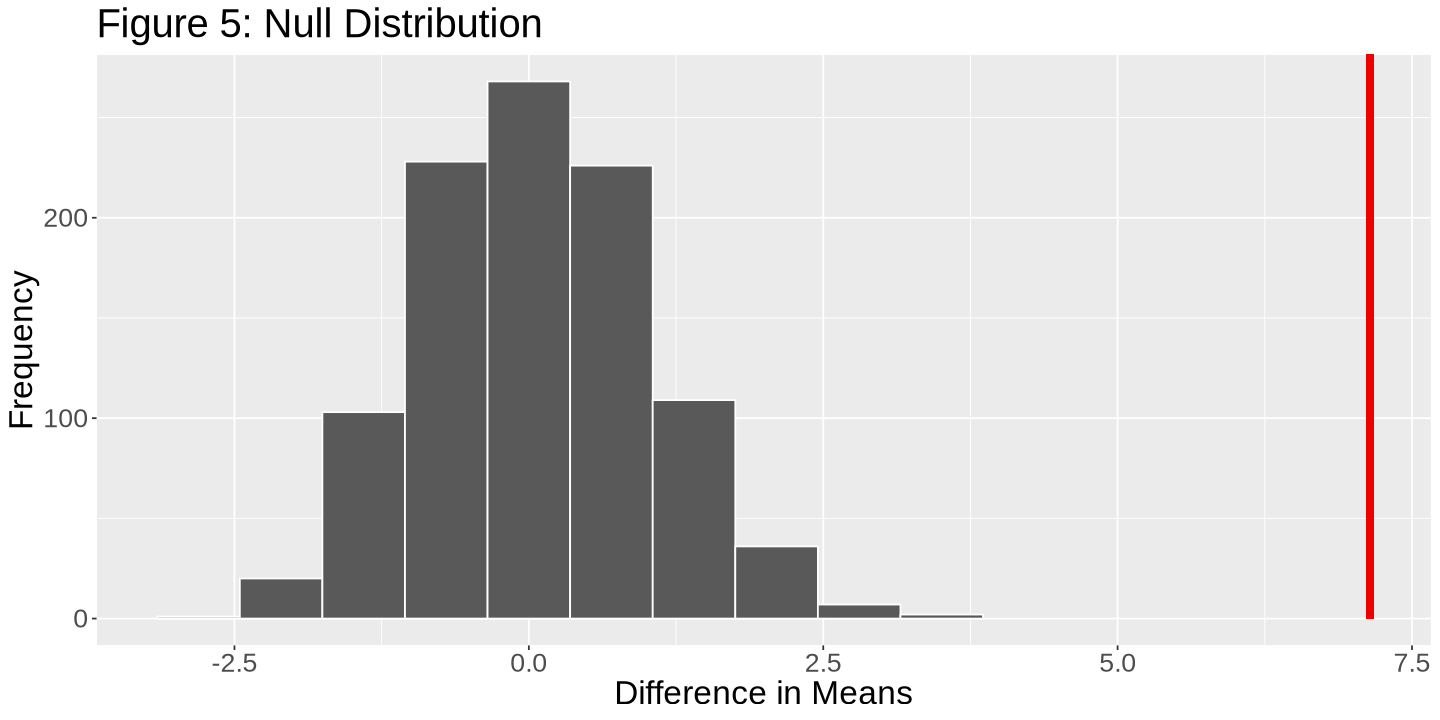

In [21]:
diff_in_means_plot <-
    visualize(null_diff_in_means, bins = 10) + 
    shade_p_value(obs_stat = obs_diff_in_means, direction = "right") + 
    xlab("Difference in Means") + 
    ylab("Frequency") + 
    ggtitle("Figure 5: Null Distribution") + 
    theme(text = element_text(size = 20))

options(repr.plot.width = 12, repr.plot.height = 6)
diff_in_means_plot

This plot of the null distribution and observed statistic visually confirms the above results. The observed difference in means is very extreme compared to the null model, and is more extreme than every statistic in the null model.

### Theory-based Hypothesis Test
From the bootstrap hypothesis test, we know the $p$-value is very small. We now do a theory-based hypothesis test, to approximate the $p$-value. While we noted earlier the advantages of the bootstrapping method, we also discovered one of its flaws during our earlier work: our statistic was so extreme that we could not obtain a nonzero $p$-value, due to the nature of the simulation.

We do a one-sided t-test, because we believe that spam email will contain more capital letters on average than non-spam, and because we do not know the true standard deviation of the difference in average capital letter run. We use the function `t.test()` to conduct the two-sample, one-sided t-test, and use `tidy()` to make the results more readable.

In [22]:
set.seed(1048596)

# Two-sample T test.
print("Table 8: p Value Computed Using Asymptotics and a Two-Sample T-test.")
tidy(t.test(x = filter(spambase_selected, class == "spam")$capital_run_length_average,
            y = filter(spambase_selected, class == "non-spam")$capital_run_length_average,
            alternative = "greater"))

[1] "Table 8: p Value Computed Using Asymptotics and a Two-Sample T-test."


estimate,estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
7.145045,9.522345,2.377301,6.079311,7.322707e-10,1835.791,5.210864,Inf,Welch Two Sample t-test,greater


Using this method, we obtain a $p$-value of $7.32\times10^{-10}$. This is an extremely low value, as would be expected given the results of our bootstrapping hypothesis test.

Because our $p$-value is less than $\alpha = 0.05$, we reject the null hypothesis $H_0: \mu_1 = \mu_0$. We have strong evidence to conclude that spam email has a greater mean average capital letter run than non-spam email.

In this instance, we found that asymptotics were more reliable than bootstrapping. A $p$-value of $0$ is  dangerous, so the asymptotic value is preferable. However, both methods gave similar results, which makes sense given that they both approximate the probability of observing a value as or more extreme than the sample statistic, if the null hypothesis were true. The fact that both $p$-values would lead to rejecting the null hypothesis means that while one was more useful than the other, both methods performed as expected.

## Discussion

#### Implications of our findings

In this report, we deduced that the mean average capital letter sequence length of spam emails is greater than that of non-spam emails. Our preliminary analysis also suggested this would be the conclusion. We calculated $95\%$ confidence intervals (using both bootstrapping and theory-based approaches) that gave the plausible difference in means to be between (depending on the method used) $5.0$ and $9.7$. Finally, we performed hypothesis testing using both bootstrapping and theory-based approaches, which yielded extremely small $p$-values in both cases. These results led us to reject the null hypothesis: that mean average length of uninterrupted sequences of capital letters is the same for spam emails and non-spam emails.

#### Results and initial expectations

These results were as we expected, given our preliminary analysis and our initial intuition that spam emails would use more capital letters to grab attention and convey a sense of urgency.

#### Future questions and research

These results imply that the length of capital letter sequences is a fantastic indicator of whether or not an email is spam. We believe this information can aid individuals and AI model creators who are interested in keeping inboxes free of unsolicited messages, or help legitimate marketers avoid being mistaken for spam by reducing their capital letter usage. We believe followup research could explore the other variables in the `Spambase` dataset to find other differences between spam and non-spam. An application of our findings could be to train a model, such as a logistic regression model, capable of classifying email as spam and non-spam email.

## References

Hopkins, M., Reeber, E., Forman, G., & Suermondt, J. (1999). Spambase. UCI Machine Learning Repository.
https://doi.org/10.24432/C53G6X.

Cranor, L. F., & LaMacchia, B. A. (1998, August). Spam! *Communications of the ACM*, 41(8), 74–83. https://doi.org/10.1145/280324.280336.

Wang, Irani, & Pu. (2013, October 20). A study on evolution of email spam over fifteen years. *9th IEEE International Conference on Collaborative Computing: Networking, Applications and Worksharing*. http://dx.doi.org/10.4108/icst.collaboratecom.2013.254082.

RDocumentation. (n.d.). get_p_value function. https://www.rdocumentation.org/packages/infer/versions/0.5.3/topics/get_p_value